In [2]:
import pandas as pd
import os
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

import pandas as pd
import os
import matplotlib.pyplot as pyplot

pd.options.mode.chained_assignment = None
import numpy as np
# Define the directory path where the files are located
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Initialize an empty DataFrame to store the merged data
dataset_path = "../../dataset/processed_data/main/timeseries/final_cleaned_TimeSeries_dataset.xlsx"
df =  pd.read_excel( dataset_path )

del df[df. columns[0]] 
df.head()

,District,"Laboratory confirmed, since the beginning of the pandemic TOTAL","Laboratory confirmed, since the beginning of the pandemic Difference from","Laboratory confirmed, since the beginning of the pandemic Hospitalized","Laboratory confirmed, since the beginning of the pandemic Deceased","Laboratory confirmed, since the beginning of the pandemic RecoveredA","Laboratory confirmed, since the beginning of the pandemic Current CasesB","Reported, the last 7 days,Incidence per 100, Incidence per 100 ,+USAFD","Reported, the last 7 days,Incidence per 100, Incidence per 100 ,<20 Jahre","Reported, the last 7 days,Incidence per 100, Incidence per 100 ,20-59 JahreE","Reported, the last 7 days,Incidence per 100, Incidence per 100 ,>=60 Jahre",Date
0,Ahrweiler,4577,4,199,52.0,4423,102,50.0,132.2,49.0,7.1,2021-08-01
1,Altenkirchen,4956,0,411,101.0,4833,22,8.5,8.4,12.1,2.6,2021-08-01
2,Alzey-Worms,5130,1,304,123.0,4970,37,9.3,24.0,4.4,8.2,2021-08-01
3,Bad Dürkheim,4499,1,305,150.0,4303,46,14.3,21.6,19.5,2.3,2021-08-01
4,Bad Kreuznach,6121,0,160,142.0,5923,56,18.3,41.4,20.0,2.0,2021-08-01


In [3]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg



In [4]:
target_variable = 'Laboratory confirmed, since the beginning of the pandemic Hospitalized'

df = df.set_index('Date')
input_features = df.drop(["District"], axis=1).values


In [5]:
reframed = series_to_supervised(input_features, 1, 1)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1     4577.0        4.0      199.0       52.0     4423.0      102.0   
2     4956.0        0.0      411.0      101.0     4833.0       22.0   
3     5130.0        1.0      304.0      123.0     4970.0       37.0   
4     4499.0        1.0      305.0      150.0     4303.0       46.0   
5     6121.0        0.0      160.0      142.0     5923.0       56.0   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var1(t)  var2(t)  var3(t)  \
1       50.0      132.2       49.0         7.1   4956.0      0.0    411.0   
2        8.5        8.4       12.1         2.6   5130.0      1.0    304.0   
3        9.3       24.0        4.4         8.2   4499.0      1.0    305.0   
4       14.3       21.6       19.5         2.3   6121.0      0.0    160.0   
5       18.3       41.4       20.0         2.0   3121.0      4.0    286.0   

   var4(t)  var5(t)  var6(t)  var7(t)  var8(t)  var9(t)  var10(t)  
1    101.0   4833.0     22.0      8.5     

In [6]:

# split into train and test sets
values = reframed.values
n_train_hours = 365
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(365, 1, 19) (365,) (16334, 1, 19) (16334,)


Epoch 1/50
6/6 - 10s - loss: 54.7702 - val_loss: 589486.6875
Epoch 2/50
6/6 - 0s - loss: 53.3317 - val_loss: 589338.3125
Epoch 3/50
6/6 - 0s - loss: 51.8690 - val_loss: 589184.6250
Epoch 4/50
6/6 - 0s - loss: 50.5971 - val_loss: 589026.5000
Epoch 5/50
6/6 - 0s - loss: 49.1304 - val_loss: 588847.9375
Epoch 6/50
6/6 - 0s - loss: 47.6428 - val_loss: 588659.8125
Epoch 7/50
6/6 - 0s - loss: 46.2261 - val_loss: 588457.1250
Epoch 8/50
6/6 - 0s - loss: 44.5888 - val_loss: 588229.8125
Epoch 9/50
6/6 - 0s - loss: 43.0096 - val_loss: 587989.3750
Epoch 10/50
6/6 - 0s - loss: 41.3622 - val_loss: 587727.5000
Epoch 11/50
6/6 - 0s - loss: 39.9478 - val_loss: 587460.0625
Epoch 12/50
6/6 - 0s - loss: 38.5489 - val_loss: 587194.1875
Epoch 13/50
6/6 - 0s - loss: 37.1818 - val_loss: 586919.1250
Epoch 14/50
6/6 - 0s - loss: 36.1251 - val_loss: 586625.9375
Epoch 15/50
6/6 - 0s - loss: 35.2028 - val_loss: 586362.3125
Epoch 16/50
6/6 - 0s - loss: 34.5256 - val_loss: 586090.6250
Epoch 17/50
6/6 - 0s - loss: 33.

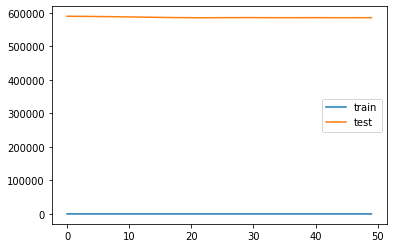

In [7]:
# design network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=True)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()